In [ ]:
# Setup
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer

# Use GPU when available for faster training/visuals; fall back to CPU otherwise
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using', DEVICE)

ds = load_dataset("wikitext", "wikitext-2-v1", verification_mode="no_checks")

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda


In [87]:
def scaled_dot_product_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, mask: torch.Tensor|None=None):
    """Compute scaled dot-product attention.

    Implements the equation from "Attention is All You Need":

        Attention(Q, K, V) = softmax(Q K^T / sqrt(d_k) + mask) V

    Args:
        Q: Query tensor of shape (B, h, T_q, d_k).
        K: Key tensor of shape (B, h, T_k, d_k).
        V: Value tensor of shape (B, h, T_k, d_v).
        mask: Optional additive mask broadcastable to (B, h, T_q, T_k) with 0 or -inf.

    Returns:
        out: Attention output, shape (B, h, T_q, d_v).
        attn: Attention weights (softmax probabilities), shape (B, h, T_q, T_k).
    """
    # d_k is the dimensionality of queries/keys per head
    d_k = Q.size(-1)  # read last dimension of Q for scaling

    # Compute raw attention scores by matrix-multiplying Q and K^T
    # Q @ K^T yields shape (B, h, T_q, T_k)
    #TODO
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)# scale by sqrt(d_k)

    # If a mask was provided, add it to the scores. Mask entries are 0 (keep) or -inf (block)
    if mask is not None:
        # Ensure mask is same dtype and on same device as scores to avoid runtime errors
        mask = mask.to(dtype=scores.dtype, device=scores.device)
        scores = scores + mask  # additive masking prior to softmax

    # Convert scores to probabilities along the key dimension with softmax
    # use torch functional library you important above, which is a PyTorch
    # module containing functional (stateless) implementations of layers
    # and operations like softmax, relu, cross_entropy, etc.
    #TODO
    attn = F.softmax(scores, dim=-1)  # softmax over T_k

    # Use attention weights to produce weighted sum over values
    # This line of code will perform a batched matrix multiplication over the last two dimensions
    out = torch.matmul(attn, V) # (B, h, T_q, d_v)

    # Return both the attended outputs and the attention weights for inspection
    return out, attn

# Quick shape test: verify the function returns expected tensor shapes
B, h, T, d_k, d_v = 2, 3, 4, 8, 8  # batch, heads, time, key-dim, value-dim
Q = torch.randn(B, h, T, d_k)  # random queries
K = torch.randn(B, h, T, d_k)  # random keys
V = torch.randn(B, h, T, d_v)  # random values
out, attn = scaled_dot_product_attention(Q, K, V)  # call the function
assert out.shape == (B, h, T, d_v) and attn.shape == (B, h, T, T)  # sanity assert
print('Scaled dot-product attention shapes OK:', out.shape, attn.shape)

Scaled dot-product attention shapes OK: torch.Size([2, 3, 4, 8]) torch.Size([2, 3, 4, 4])


In [88]:
def sinusoidal_positional_encoding(T:int, d_model:int, device=DEVICE):
    """Create sinusoidal positional encodings.

    Implements the original formulation from Vaswani et al. where each dimension
    of the positional encoding uses a different frequency.

    Args:
        T: Sequence length (number of positions).
        d_model: Model dimensionality (must be even to pair sin/cos dims nicely).
        device: Torch device for the returned tensor.

    Returns:
        PE: Tensor of shape (T, d_model) containing positional encodings.
    """
    # Ensure d_model is even so even/odd pairing works
    assert d_model % 2 == 0, "d_model must be even for sinusoidal positional encoding"

    # position indices (T, 1) as float
    pos = torch.arange(T, device=device, dtype=torch.float32).unsqueeze(1)

    # dimension indices (1, d_model) as float
    i = torch.arange(d_model, device=device, dtype=torch.float32).unsqueeze(0)

    # compute the rate term 1/10000^{2i/d_model}
    angle_rates = 1.0 / torch.pow(10000.0, (2 * (i // 2)) / d_model)

    # outer product to get angles for every position and dimension
    angles = pos * angle_rates  # (T, d_model)

    # allocate and fill even/odd indices with sin/cos
    PE = torch.zeros((T, d_model), device=device)
    PE[:, 0::2] = torch.sin(angles[:, 0::2])
    PE[:, 1::2] = torch.cos(angles[:, 1::2])
    return PE


def causal_mask(T_q: int, T_k: int, device=DEVICE, dtype: torch.dtype=torch.float32):
    """Create an additive causal mask to prevent attention to future positions.

    The mask returned can be added directly to attention logits before softmax.

    Args:
        T_q: Number of query positions.
        T_k: Number of key/value positions.
        device: Torch device to create the mask on.
        dtype: Desired floating dtype for the returned mask (default: torch.float32).

    Returns:
        mask: Tensor of shape (1, 1, T_q, T_k) with 0.0 where allowed and -inf where masked.
    """
    # Allocate a mask filled with -inf (all positions masked initially) with requested dtype
    mask = torch.full((1,1,T_q,T_k), float('-inf'), device=device, dtype=dtype)

    # Build a lower-triangular matrix of ones (allowed positions are 1)
    tril = torch.tril(torch.ones(T_q, T_k, device=device, dtype=dtype))

    # Wherever tril == 1, set the mask value to 0.0 (meaning "allowed")
    mask = mask.masked_fill(tril == 1, 0.0)

    # Return mask shaped (1,1,T_q,T_k) which will broadcast over batch and heads
    return mask

In [89]:
class TinyMultiHeadAttention(nn.Module):
    """A minimal multi-head self-attention implementation.

    This class implements the core mechanics of multi-head attention without
    dropout or biases. It projects inputs to Q/K/V, splits into heads, applies
    scaled dot-product attention per head, and concatenates the results.
    """
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        # Ensure d_model is divisible by number of heads for equal head size
        assert d_model % num_heads == 0
        self.d_model = d_model  # full model dimensionality
        self.num_heads = num_heads  # number of parallel attention heads
        self.d_k = d_model // num_heads  # dimensionality per head

        # Linear projections for queries, keys and values (project then split into heads)
        self.W_q = nn.Linear(d_model, d_model, bias=False)  # projects input -> Q_all
        self.W_k = nn.Linear(d_model, d_model, bias=False)  # projects input -> K_all
        self.W_v = nn.Linear(d_model, d_model, bias=False)  # projects input -> V_all

        # Output linear projection that combines concatenated head outputs
        self.W_o = nn.Linear(d_model, d_model, bias=False)  # projects heads concat -> output

    def split_heads(self, X):
        """Split the last dimension into (num_heads, d_k) and transpose.

        Args:
            X: Tensor of shape (B, T, D)
        Returns:
            Tensor of shape (B, h, T, d_k)
        """
        # Unpack batch, time, and feature dims
        B, T, D = X.shape
        # Reshape to separate heads and then transpose head dim upfront
        X = X.view(B, T, self.num_heads, self.d_k).transpose(1,2)  # (B,h,T,d_k)
        return X

    def combine_heads(self, X):
        """Inverse of split_heads: transpose and merge heads into feature dim.

        Args:
            X: Tensor of shape (B, h, T, d_k)
        Returns:
            Tensor of shape (B, T, D)
        """
        # Unpack shapes
        B, h, T, d_k = X.shape
        # Transpose to (B, T, h, d_k) then flatten the last two dims
        X = X.transpose(1,2).contiguous().view(B, T, h*d_k)  # (B,T,D)
        return X

    def forward(self, X, mask=None):
        """Forward pass for TinyMultiHeadAttention.

        Args:
            X: Input tensor of shape (B, T, D=d_model).
            mask: Optional additive mask to apply to attention logits.

        Returns:
            out_proj: Output tensor of shape (B, T, D).
            attn: Attention weights from scaled_dot_product_attention (B, h, T, T).
        """
        # Project inputs to combined Q/K/V of shape (B, T, D)
        Q_all = self.W_q(X)  # (B, T, D)
        K_all = self.W_k(X)  # (B, T, D)
        V_all = self.W_v(X)  # (B, T, D)

        # Split the combined Q/K/V into multiple heads: (B, h, T, d_k)
        Q = self.split_heads(Q_all)
        K = self.split_heads(K_all)
        V = self.split_heads(V_all)

        # Compute attention per head using scaled dot-product attention
        out, attn = scaled_dot_product_attention(Q, K, V, mask)

        # Combine head outputs back into (B, T, D)
        out_combined = self.combine_heads(out)

        # Final linear projection
        out_proj = self.W_o(out_combined)

        return out_proj, attn

# Sanity check
B,T,D,h = 2,5,32,4
x = torch.randn(B,T,D)
mha = TinyMultiHeadAttention(D,h)
y, attn = mha(x)
print('Tiny MHA out shape:', y.shape, '| attn:', attn.shape)


Tiny MHA out shape: torch.Size([2, 5, 32]) | attn: torch.Size([2, 4, 5, 5])


# using BPE tokenizer

In [ ]:
from tokenizers import ByteLevelBPETokenizer
from torch.utils.data import DataLoader, TensorDataset
import torch
import os

block_size = 128
batch_size = 16
max_train_sequences = 20000
max_val_sequences = 1024
max_train_docs = 200000
max_val_docs = 10000

def build_corpus(split, max_docs):
    subset = split.select(range(min(len(split), max_docs)))
    return "\n\n".join(subset["text"])

train_text = build_corpus(ds["train"], max_docs=max_train_docs)
val_text = build_corpus(ds["validation"], max_docs=max_val_docs)

# save text temporarily so ByteLevelBPETokenizer can read it
os.makedirs("tokenizer_data", exist_ok=True)
with open("tokenizer_data/train.txt", "w", encoding="utf-8") as f:
    f.write(train_text)
with open("tokenizer_data/val.txt", "w", encoding="utf-8") as f:
    f.write(val_text)

tokenizer = ByteLevelBPETokenizer()

tokenizer.train(
    files=["tokenizer_data/train.txt"],
    vocab_size=50257,
    min_frequency=2,
    special_tokens=[
        "<unk>",
        "<pad>",
        "<bos>",
        "<eos>",
    ],
)

def encode_text(text):
    return tokenizer.encode(text).ids

train_ids = encode_text(train_text)
val_ids = encode_text(val_text)

max_train_tokens = block_size * max_train_sequences
max_val_tokens = block_size * max_val_sequences

def ids_to_chunks(token_ids, max_tokens):
    usable = min(len(token_ids), max_tokens)
    usable = (usable // block_size) * block_size
    tensor = torch.tensor(token_ids[:usable], dtype=torch.long)
    return tensor.view(-1, block_size)

train_chunks = ids_to_chunks(train_ids, max_train_tokens)
val_chunks = ids_to_chunks(val_ids, max_val_tokens)

print(f"Prepared {train_chunks.shape[0]} train chunks ({train_chunks.numel():,} tokens)")
print(f"Prepared {val_chunks.shape[0]} val chunks   ({val_chunks.numel():,} tokens)")

train_dataset = TensorDataset(train_chunks)
val_dataset = TensorDataset(val_chunks)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


Prepared 17611 train chunks (2,254,208 tokens)
Prepared 1024 val chunks   (131,072 tokens)


In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, mlp_ratio: int = 4, dropout: float = 0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = TinyMultiHeadAttention(d_model, num_heads)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, mlp_ratio * d_model),
            nn.GELU(),
            nn.Linear(mlp_ratio * d_model, d_model),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_out, attn_weights = self.attn(self.ln1(x), mask)
        x = x + self.dropout(attn_out)
        ff_out = self.ff(self.ln2(x))
        x = x + self.dropout(ff_out)
        return x, attn_weights


class MiniGPT(nn.Module):
    def __init__(self, vocab_size: int, d_model: int = 256, num_layers: int = 4,
                 num_heads: int = 4, block_size: int = 128, dropout: float = 0.1):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, d_model)
        pe = sinusoidal_positional_encoding(block_size, d_model)
        self.register_buffer("pos_emb", pe.unsqueeze(0))
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, dropout=dropout) for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx, return_attn: bool = False):
        B, T = idx.shape
        if T > self.block_size:
            idx = idx[:, -self.block_size:]
            T = idx.shape[1]
        tok = self.token_emb(idx)
        pos = self.pos_emb[:, :T, :]
        x = tok + pos
        mask = causal_mask(T, T, device=idx.device, dtype=tok.dtype)
        attn_maps = []
        for block in self.blocks:
            x, attn = block(x, mask)
            if return_attn:
                attn_maps.append(attn)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if return_attn:
            return logits, attn_maps
        return logits, None

    # generation for bpe tokenizer
    @torch.no_grad()
    def generate(model, idx, max_new_tokens=50, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            logits, _ = model(idx)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, ix = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float("inf")
            probs = torch.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_id], dim=1)
            if next_id.item() == tokenizer.token_to_id("<eos>"):
                break
        return idx



In [114]:
torch.cuda.empty_cache()

In [115]:
d_model = 512
num_layers = 6
num_heads = 8
learning_rate = 1e-4
num_epochs = 10
dropout = 0.3

model = MiniGPT(vocab_size=tokenizer.get_vocab_size(), d_model=d_model,
                num_layers=num_layers, num_heads=num_heads,
                block_size=block_size, dropout=dropout).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)


def compute_loss(logits, targets):
    # shift for next-token prediction
    return F.cross_entropy(
        logits[:, :-1, :].reshape(-1, logits.size(-1)),
        targets[:, 1:].reshape(-1)
    )


def run_epoch(loader, train: bool = True):
    total_loss = 0.0
    n_batches = 0
    if train:
        model.train()
    else:
        model.eval()
    for (batch,) in loader:
        batch = batch.to(DEVICE)
        if train:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits, _ = model(batch)
            loss = compute_loss(logits, batch)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(n_batches, 1)

print(f'PARAMS:\n\
        d_model = {d_model}\n\
        num_layers = {num_layers}\n\
        num_heads = {num_heads}\n\
        learning_rate = {learning_rate}\n\
        dropout = {dropout}')
history = []
for epoch in range(1, num_epochs + 1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    val_ppl = math.exp(val_loss)
    history.append((train_loss, val_loss, val_ppl))
    print(f"Epoch {epoch}: train_loss={train_loss:.3f} | val_loss={val_loss:.3f} | val_ppl={val_ppl:.1f}")


PARAMS:
        d_model = 512
        num_layers = 6
        num_heads = 8
        learning_rate = 0.0001
        dropout = 0.3
Epoch 1: train_loss=5.989 | val_loss=5.146 | val_ppl=171.8
Epoch 2: train_loss=5.269 | val_loss=4.872 | val_ppl=130.6
Epoch 3: train_loss=4.938 | val_loss=4.702 | val_ppl=110.2
Epoch 4: train_loss=4.682 | val_loss=4.600 | val_ppl=99.4
Epoch 5: train_loss=4.465 | val_loss=4.522 | val_ppl=92.1
Epoch 6: train_loss=4.275 | val_loss=4.480 | val_ppl=88.2
Epoch 7: train_loss=4.100 | val_loss=4.440 | val_ppl=84.8
Epoch 8: train_loss=3.937 | val_loss=4.435 | val_ppl=84.4
Epoch 9: train_loss=3.783 | val_loss=4.440 | val_ppl=84.7
Epoch 10: train_loss=3.638 | val_loss=4.456 | val_ppl=86.2


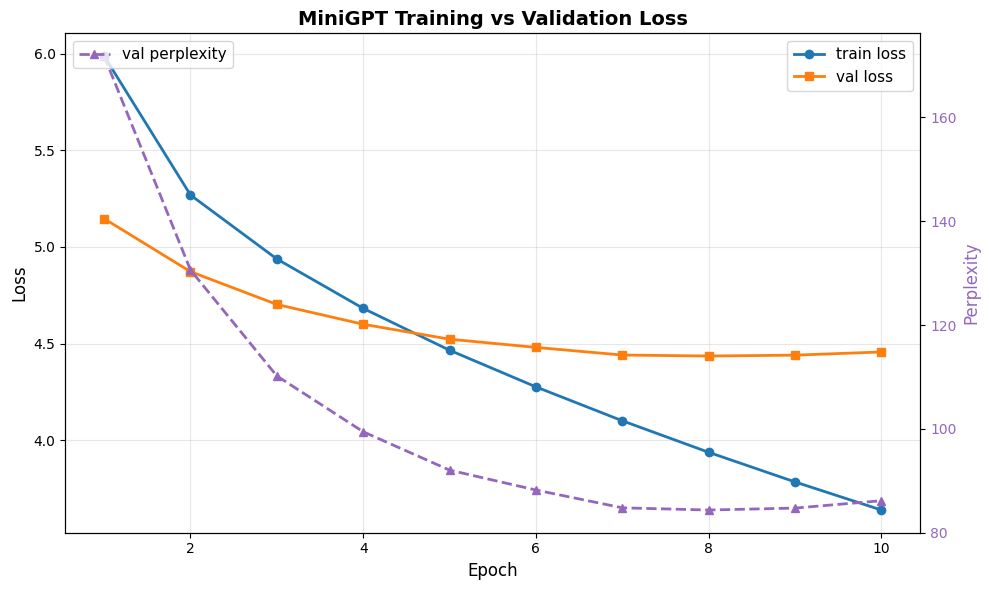


Training Summary:
  Final train loss: 3.638
  Final val loss: 4.456
  Final val perplexity: 86.2
  Best val perplexity: 84.4 (epoch 8)


In [116]:
if history:
    epochs = list(range(1, len(history) + 1))
    train_losses = [h[0] for h in history]
    val_losses = [h[1] for h in history]
    val_ppls = [h[2] for h in history]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(epochs, train_losses, label='train loss', marker='o', linewidth=2)
    ax1.plot(epochs, val_losses, label='val loss', marker='s', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('MiniGPT Training vs Validation Loss', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=11)

    ax2 = ax1.twinx()
    ax2.plot(epochs, val_ppls, color='tab:purple', label='val perplexity', linestyle='--', marker='^', linewidth=2)
    ax2.set_ylabel('Perplexity', fontsize=12, color='tab:purple')
    ax2.tick_params(axis='y', labelcolor='tab:purple')
    ax2.legend(loc='upper left', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTraining Summary:")
    print(f"  Final train loss: {train_losses[-1]:.3f}")
    print(f"  Final val loss: {val_losses[-1]:.3f}")
    print(f"  Final val perplexity: {val_ppls[-1]:.1f}")
    print(f"  Best val perplexity: {min(val_ppls):.1f} (epoch {epochs[val_ppls.index(min(val_ppls))]})")
else:
    print('History is empty; run the training cell first.')


In [118]:
prompt = "The history of natural language processing"

bos_id = tokenizer.token_to_id("<bos>")
prompt_ids = [bos_id] + tokenizer.encode(prompt).ids
input_ids = torch.tensor([prompt_ids], device=DEVICE)

with torch.no_grad():
    generated_ids = model.generate(
        input_ids,
        max_new_tokens=50,
        temperature=0.9,
        top_k=50
    )
print(
    tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=True)
)


The history of natural language processing styles . In the 17th century , the architect of William  wrote about it " the site of a ritual " . 


 The Chapel of Jesus described Christ as a part of the cathedral @-@ religious architecture , with a church built from


SentencePiece

In [119]:
import sentencepiece as spm

block_size = 128
batch_size = 16
max_train_sequences = 20000
max_val_sequences = 1024
max_train_docs = 200000
max_val_docs = 10000

def build_corpus(split, max_docs):
    subset = split.select(range(min(len(split), max_docs)))
    return "\n\n".join(subset["text"])

train_text = build_corpus(ds["train"], max_docs=max_train_docs)
val_text = build_corpus(ds["validation"], max_docs=max_val_docs)

spm_model_prefix = "tokenizer_data/spm_model"

# Load the trained SentencePiece model
tokenizer = spm.SentencePieceProcessor()
tokenizer.load(f"{spm_model_prefix}.model")

def encode_text(text):
    return tokenizer.encode(text, out_type=int)

train_ids = encode_text(train_text)
val_ids  = encode_text(val_text)

max_train_tokens = block_size * max_train_sequences
max_val_tokens   = block_size * max_val_sequences

def ids_to_chunks(token_ids, max_tokens):
    usable = min(len(token_ids), max_tokens)
    usable = (usable // block_size) * block_size
    tensor = torch.tensor(token_ids[:usable], dtype=torch.long)
    return tensor.view(-1, block_size)

train_chunks = ids_to_chunks(train_ids, max_train_tokens)
val_chunks   = ids_to_chunks(val_ids, max_val_tokens)

print(f"Prepared {train_chunks.shape[0]} train chunks ({train_chunks.numel():,} tokens)")
print(f"Prepared {val_chunks.shape[0]} val chunks   ({val_chunks.numel():,} tokens)")
print(f"Vocabulary size: {tokenizer.get_piece_size()}")

train_dataset = TensorDataset(train_chunks)
val_dataset   = TensorDataset(val_chunks)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)


Prepared 17575 train chunks (2,249,600 tokens)
Prepared 1024 val chunks   (131,072 tokens)
Vocabulary size: 50257


In [125]:
class DecoderBlock(nn.Module):
    """Transformer decoder block with pre-norm residual layout."""
    def __init__(self, d_model: int, num_heads: int, mlp_ratio: int = 4, dropout: float = 0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = TinyMultiHeadAttention(d_model, num_heads)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, mlp_ratio * d_model),
            nn.GELU(),
            nn.Linear(mlp_ratio * d_model, d_model),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_out, attn_weights = self.attn(self.ln1(x), mask)
        x = x + self.dropout(attn_out)
        ff_out = self.ff(self.ln2(x))
        x = x + self.dropout(ff_out)
        return x, attn_weights


class MiniGPT(nn.Module):
    """Compact decoder-only transformer for language modeling."""
    def __init__(self, vocab_size: int, d_model: int = 256, num_layers: int = 4,
                 num_heads: int = 4, block_size: int = 128, dropout: float = 0.1):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, d_model)
        pe = sinusoidal_positional_encoding(block_size, d_model)
        self.register_buffer("pos_emb", pe.unsqueeze(0))  # (1, block_size, d_model)
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, dropout=dropout) for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx, return_attn: bool = False):
        B, T = idx.shape
        if T > self.block_size:
            idx = idx[:, -self.block_size:]
            T = idx.shape[1]
        tok = self.token_emb(idx)
        pos = self.pos_emb[:, :T, :]
        x = tok + pos
        mask = causal_mask(T, T, device=idx.device, dtype=tok.dtype)
        attn_maps = []
        for block in self.blocks:
            x, attn = block(x, mask)
            if return_attn:
                attn_maps.append(attn)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if return_attn:
            return logits, attn_maps
        return logits, None


    @torch.no_grad()
    def generate(model, idx, max_new_tokens=50, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            logits, _ = model(idx)
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                v, ix = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float("inf")

            probs = torch.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_id], dim=1)
            if next_id.item() == tokenizer.PieceToId("<eos>"):
                break

        return idx



In [127]:
torch.cuda.empty_cache()

In [128]:
d_model = 512
num_layers = 6
num_heads = 8
learning_rate = 1e-4
num_epochs = 10
dropout = 0.35

model = MiniGPT(vocab_size=tokenizer.get_piece_size(), d_model=d_model,
                num_layers=num_layers, num_heads=num_heads,
                block_size=block_size, dropout=dropout).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)


def compute_loss(logits, targets):
    # shift for next-token prediction
    return F.cross_entropy(
        logits[:, :-1, :].reshape(-1, logits.size(-1)),
        targets[:, 1:].reshape(-1)
    )


def run_epoch(loader, train: bool = True):
    total_loss = 0.0
    n_batches = 0
    if train:
        model.train()
    else:
        model.eval()
    for (batch,) in loader:
        batch = batch.to(DEVICE)
        if train:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits, _ = model(batch)
            loss = compute_loss(logits, batch)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(n_batches, 1)

print(f'PARAMS:\n\
        d_model = {d_model}\n\
        num_layers = {num_layers}\n\
        num_heads = {num_heads}\n\
        learning_rate = {learning_rate}\n\
        dropout = {dropout}')
history = []
for epoch in range(1, num_epochs + 1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    val_ppl = math.exp(val_loss)
    history.append((train_loss, val_loss, val_ppl))
    print(f"Epoch {epoch}: train_loss={train_loss:.3f} | val_loss={val_loss:.3f} | val_ppl={val_ppl:.1f}")


PARAMS:
        d_model = 512
        num_layers = 6
        num_heads = 8
        learning_rate = 0.0001
        dropout = 0.35
Epoch 1: train_loss=6.003 | val_loss=4.906 | val_ppl=135.2
Epoch 2: train_loss=5.292 | val_loss=4.645 | val_ppl=104.1
Epoch 3: train_loss=4.963 | val_loss=4.486 | val_ppl=88.8
Epoch 4: train_loss=4.708 | val_loss=4.382 | val_ppl=80.0
Epoch 5: train_loss=4.495 | val_loss=4.298 | val_ppl=73.5
Epoch 6: train_loss=4.309 | val_loss=4.248 | val_ppl=69.9
Epoch 7: train_loss=4.141 | val_loss=4.227 | val_ppl=68.5
Epoch 8: train_loss=3.985 | val_loss=4.210 | val_ppl=67.4
Epoch 9: train_loss=3.839 | val_loss=4.202 | val_ppl=66.8
Epoch 10: train_loss=3.700 | val_loss=4.206 | val_ppl=67.1


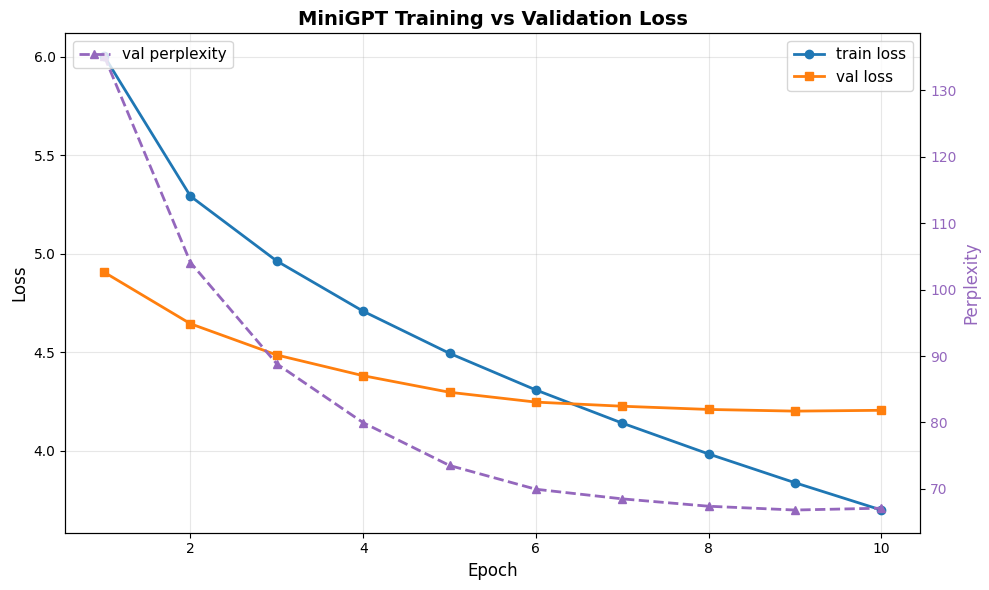


Training Summary:
  Final train loss: 3.700
  Final val loss: 4.206
  Final val perplexity: 67.1
  Best val perplexity: 66.8 (epoch 9)


In [129]:
# Plot training curves
if history:
    epochs = list(range(1, len(history) + 1))
    train_losses = [h[0] for h in history]
    val_losses = [h[1] for h in history]
    val_ppls = [h[2] for h in history]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(epochs, train_losses, label='train loss', marker='o', linewidth=2)
    ax1.plot(epochs, val_losses, label='val loss', marker='s', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('MiniGPT Training vs Validation Loss', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=11)

    ax2 = ax1.twinx()
    ax2.plot(epochs, val_ppls, color='tab:purple', label='val perplexity', linestyle='--', marker='^', linewidth=2)
    ax2.set_ylabel('Perplexity', fontsize=12, color='tab:purple')
    ax2.tick_params(axis='y', labelcolor='tab:purple')
    ax2.legend(loc='upper left', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTraining Summary:")
    print(f"  Final train loss: {train_losses[-1]:.3f}")
    print(f"  Final val loss: {val_losses[-1]:.3f}")
    print(f"  Final val perplexity: {val_ppls[-1]:.1f}")
    print(f"  Best val perplexity: {min(val_ppls):.1f} (epoch {epochs[val_ppls.index(min(val_ppls))]})")
else:
    print('History is empty; run the training cell first.')


In [132]:
prompt = "The history of natural language processing"

bos_id = tokenizer.PieceToId("<bos>")
prompt_ids = [bos_id] + tokenizer.encode(prompt)
input_ids = torch.tensor([prompt_ids], device=DEVICE)

with torch.no_grad():
    generated_ids = model.generate(
        input_ids,
        max_new_tokens=50,
        temperature=0.9,
        top_k=50
    )
generated_text = tokenizer.decode(generated_ids[0].tolist())
print(generated_text)

The history of natural language processing . The most recent evidence of these groups have been published in China and the study of European schools which included human research and culture , or by its own or early Irish language . It has been recognized by the  ⁇ unk ⁇  and English  ⁇ unk


Part 2: QA

In [133]:
try:
    import accelerate
    print(f"✓ accelerate is already installed (version: {accelerate.__version__})")
    print("If you get an accelerate error in later cells, RESTART THE KERNEL and run all cells again.")
except ImportError:
    print("Installing accelerate...")
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "accelerate>=0.26.0"])
    print("✓ accelerate installed successfully!")
    print("\n⚠️  IMPORTANT: Please RESTART THE KERNEL now, then run all cells from the beginning.")
    print("   (Kernel -> Restart Kernel, then run all cells)")
    import accelerate
    print(f"✓ accelerate version: {accelerate.__version__}")

✓ accelerate is already installed (version: 1.12.0)
If you get an accelerate error in later cells, RESTART THE KERNEL and run all cells again.


In [134]:
# Load SQuAD v1 dataset for question answering
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import DefaultDataCollator
import numpy as np

# Load SQuAD v1 dataset
print("Loading SQuAD v1 dataset...")
squad = load_dataset("squad")
print(f"Train samples: {len(squad['train'])}")
print(f"Validation samples: {len(squad['validation'])}")
print(f"\nSample question: {squad['train'][0]['question']}")
print(f"Context: {squad['train'][0]['context'][:200]}...")
print(f"Answer: {squad['train'][0]['answers']['text'][0]}")


Loading SQuAD v1 dataset...
Train samples: 87599
Validation samples: 10570

Sample question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper sta...
Answer: Saint Bernadette Soubirous


In [137]:
# Load DistilGPT-2 model and tokenizer for question answering
from transformers import GPT2ForQuestionAnswering, GPT2TokenizerFast
from transformers import AutoTokenizer

print("\nLoading DistilGPT-2 for question answering...")
# Use AutoTokenizer to ensure we get the fast tokenizer
qa_tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
if not isinstance(qa_tokenizer, GPT2TokenizerFast):
    # Fallback: try to get fast tokenizer explicitly
    try:
        qa_tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
    except:
        print("Warning: Fast tokenizer not available, using regular tokenizer")
        from transformers import GPT2Tokenizer
        qa_tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")

qa_tokenizer.pad_token = qa_tokenizer.eos_token  # Set pad token
qa_model = GPT2ForQuestionAnswering.from_pretrained("distilgpt2").to(DEVICE)

print(f"Tokenizer type: {type(qa_tokenizer).__name__}")
print(f"DistilGPT-2 parameters: {sum(p.numel() for p in qa_model.parameters()):,}")
print(f"DistilGPT-2 trainable parameters: {sum(p.numel() for p in qa_model.parameters() if p.requires_grad):,}")



Loading DistilGPT-2 for question answering...


Some weights of GPT2ForQuestionAnswering were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer type: GPT2TokenizerFast
DistilGPT-2 parameters: 81,914,114
DistilGPT-2 trainable parameters: 81,914,114


In [ ]:
# Format: "Question: <question> Context: <context>" for GPT-2
def preprocess_function(examples):
    # Format as "Question: <q> Context: <c>" for GPT-2 style
    questions = [f"Question: {q.strip()}" for q in examples["question"]]
    contexts = [f" Context: {c.strip()}" for c in examples["context"]]
    combined = [q + c for q, c in zip(questions, contexts)]
    
    use_offset_mapping = hasattr(qa_tokenizer, 'is_fast') and qa_tokenizer.is_fast
    
    tokenizer_kwargs = {
        "max_length": 384,
        "truncation": True,
        "stride": 128,
        "return_overflowing_tokens": True,
        "padding": "max_length",
    }
    
    if use_offset_mapping:
        tokenizer_kwargs["return_offsets_mapping"] = True
    
    inputs = qa_tokenizer(combined, **tokenizer_kwargs)
    
    if use_offset_mapping:
        offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []
    
    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i] if i < len(sample_map) else sample_map[-1]
        answer = answers[sample_idx]
        answer_text = answer["text"][0]
        original_start_char = answer["answer_start"][0]
        
        original_context = examples["context"][sample_idx]
        original_question = examples["question"][sample_idx]
        
        question_prefix_len = len(f"Question: {original_question} Context: ")
        new_start_char = question_prefix_len + original_start_char
        new_end_char = new_start_char + len(answer_text)
        
        if use_offset_mapping and offset_mapping:
            offset = offset_mapping[i]
            answer_start_idx = None
            answer_end_idx = None
            
            for idx, (start, end) in enumerate(offset):
                if start <= new_start_char < end:
                    answer_start_idx = idx
                if start < new_end_char <= end:
                    answer_end_idx = idx
                    break
            
            if answer_start_idx is None or answer_end_idx is None:
                start_positions.append(0)
                end_positions.append(0)
            else:
                start_positions.append(answer_start_idx)
                end_positions.append(answer_end_idx)
        else:
            answer_tokens = qa_tokenizer.encode(answer_text, add_special_tokens=False)
            input_ids = inputs["input_ids"][i]
            
            answer_start_idx = None
            for j in range(len(input_ids) - len(answer_tokens) + 1):
                if input_ids[j:j+len(answer_tokens)] == answer_tokens:
                    answer_start_idx = j
                    answer_end_idx = j + len(answer_tokens) - 1
                    break
            
            if answer_start_idx is None:
                start_positions.append(0)
                end_positions.append(0)
            else:
                start_positions.append(answer_start_idx)
                end_positions.append(answer_end_idx)
    
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

# using a subset so training is sitll ~30 min
train_subset = squad["train"].select(range(min(20000, len(squad["train"]))))
val_subset = squad["validation"].select(range(min(4000, len(squad["validation"]))))

print(f"\nPreprocessing {len(train_subset)} training examples...")
tokenized_train = train_subset.map(
    preprocess_function,
    batched=True,
    remove_columns=squad["train"].column_names,
)

print(f"Preprocessing {len(val_subset)} validation examples...")
tokenized_val = val_subset.map(
    preprocess_function,
    batched=True,
    remove_columns=squad["validation"].column_names,
)

print(f"Tokenized train samples: {len(tokenized_train)}")
print(f"Tokenized validation samples: {len(tokenized_val)}")



Preprocessing 20000 training examples...
Preprocessing 4000 validation examples...


Map: 100%|██████████| 4000/4000 [00:04<00:00, 942.11 examples/s] 

Tokenized train samples: 20155
Tokenized validation samples: 4037


In [139]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./distilgpt2_squad",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=3e-5,
)

data_collator = DefaultDataCollator()

trainer = Trainer(
    model=qa_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=qa_tokenizer,
    data_collator=data_collator,
)

print("Fine-tuning DistilGPT-2 on SQuAD v1...")
trainer.train()


C:\Users\Owner\AppData\Local\Temp\ipykernel_38256\792682728.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Fine-tuning DistilGPT-2 on SQuAD v1...


Epoch,Training Loss,Validation Loss
1,2.052800,1.994612
2,1.646100,1.923905
3,1.351800,1.929588


TrainOutput(global_step=7560, training_loss=1.8721070034794076, metrics={'train_runtime': 1887.2348, 'train_samples_per_second': 32.039, 'train_steps_per_second': 4.006, 'total_flos': 5924954770076160.0, 'train_loss': 1.8721070034794076, 'epoch': 3.0})

In [140]:
# Evaluate on validation set and compute QA metrics
from transformers import pipeline
import re

# Create QA pipeline
qa_pipeline = pipeline("question-answering", model=qa_model, tokenizer=qa_tokenizer, device=0 if DEVICE == 'cuda' else -1)

# Evaluate on a sample of validation examples
def compute_qa_metrics(model, tokenizer, dataset, n_samples=100):
    exact_match = 0
    f1_scores = []
    
    for i in range(min(n_samples, len(dataset))):
        example = dataset[i]
        question = example["question"]
        context = example["context"]
        ground_truth = example["answers"]["text"][0]
        
        # Get prediction
        result = qa_pipeline(question=question, context=context)
        prediction = result["answer"]
        
        # Exact match
        if prediction.strip().lower() == ground_truth.strip().lower():
            exact_match += 1
        
        # F1 score (simple word overlap)
        pred_tokens = set(prediction.lower().split())
        truth_tokens = set(ground_truth.lower().split())
        if len(pred_tokens) == 0 and len(truth_tokens) == 0:
            f1 = 1.0
        elif len(pred_tokens) == 0 or len(truth_tokens) == 0:
            f1 = 0.0
        else:
            common = pred_tokens & truth_tokens
            precision = len(common) / len(pred_tokens) if len(pred_tokens) > 0 else 0
            recall = len(common) / len(truth_tokens) if len(truth_tokens) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    return exact_match / n_samples, np.mean(f1_scores)

print("\nEvaluating on validation set...")
em_score, f1_score = compute_qa_metrics(qa_model, qa_tokenizer, val_subset, n_samples=100)

print(f"\nDistilGPT-2 QA Results (on {min(100, len(val_subset))} samples):")
print(f"  Exact Match (EM): {em_score:.4f}")
print(f"  F1 Score: {f1_score:.4f}")


Device set to use cuda:0



Evaluating on validation set...

DistilGPT-2 QA Results (on 100 samples):
  Exact Match (EM): 0.4400
  F1 Score: 0.5197


In [142]:
# Test question answering on some examples
print("\n" + "=" * 70)
print("QUESTION ANSWERING EXAMPLES")
print("=" * 70)

test_examples = val_subset.select(range(min(10, len(val_subset))))

for i, example in enumerate(test_examples):
    question = example["question"]
    context = example["context"]
    ground_truth = example["answers"]["text"][0]
    
    # Format for GPT-2: "Question: <q> Context: <c>"
    formatted_input = f"Question: {question} Context: {context}"
    result = qa_pipeline(question=formatted_input, context=context, handle_impossible_answer=True)
    prediction = result["answer"]
    confidence = result["score"]
    
    print(f"\nExample {i+1}:")
    print(f"Question: {question}")
    print(f"Context: {context[:200]}...")
    print(f"Ground Truth: {ground_truth}")
    print(f"Prediction: {prediction} (confidence: {confidence:.3f})")
    print("-" * 70)



QUESTION ANSWERING EXAMPLES

Example 1:
Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
Ground Truth: Denver Broncos
Prediction:  Denver Broncos (confidence: 0.141)
----------------------------------------------------------------------

Example 2:
Question: Which NFL team represented the NFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
Ground Truth: Carolina Panthers
Prediction:  Denver Broncos (confidence: 0.130)
----------------------------------------------------------------------

Example 3:
Question: Where did Super Bowl 50 take place?
Context: Super Bowl 50 was an American

In [143]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Owner\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Extracting attention weights from DistilGPT-2 (QA Model)...
Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football Leagu...

Successfully extracted attention weights
Number of layers: 6
Attention matrix shape: (50, 50)
Sample tokens: ['Which', 'ĠNFL', 'Ġteam', 'Ġrepresented', 'Ġthe', 'ĠAFC', 'Ġat', 'ĠSuper', 'ĠBowl', 'Ġ50', '?', 'Ġ', 'ĠSuper', 'ĠBowl', 'Ġ50']

Attention Statistics:
  Max attention weight: 1.0000
  Mean attention weight: 0.0200
  Attention to self (diagonal mean): 0.0538

Note: This is a decoder-only model with causal attention.
      Tokens can only attend to previous tokens (upper triangular pattern).

Visualizing a specific attention head (Layer 0, Head 0)


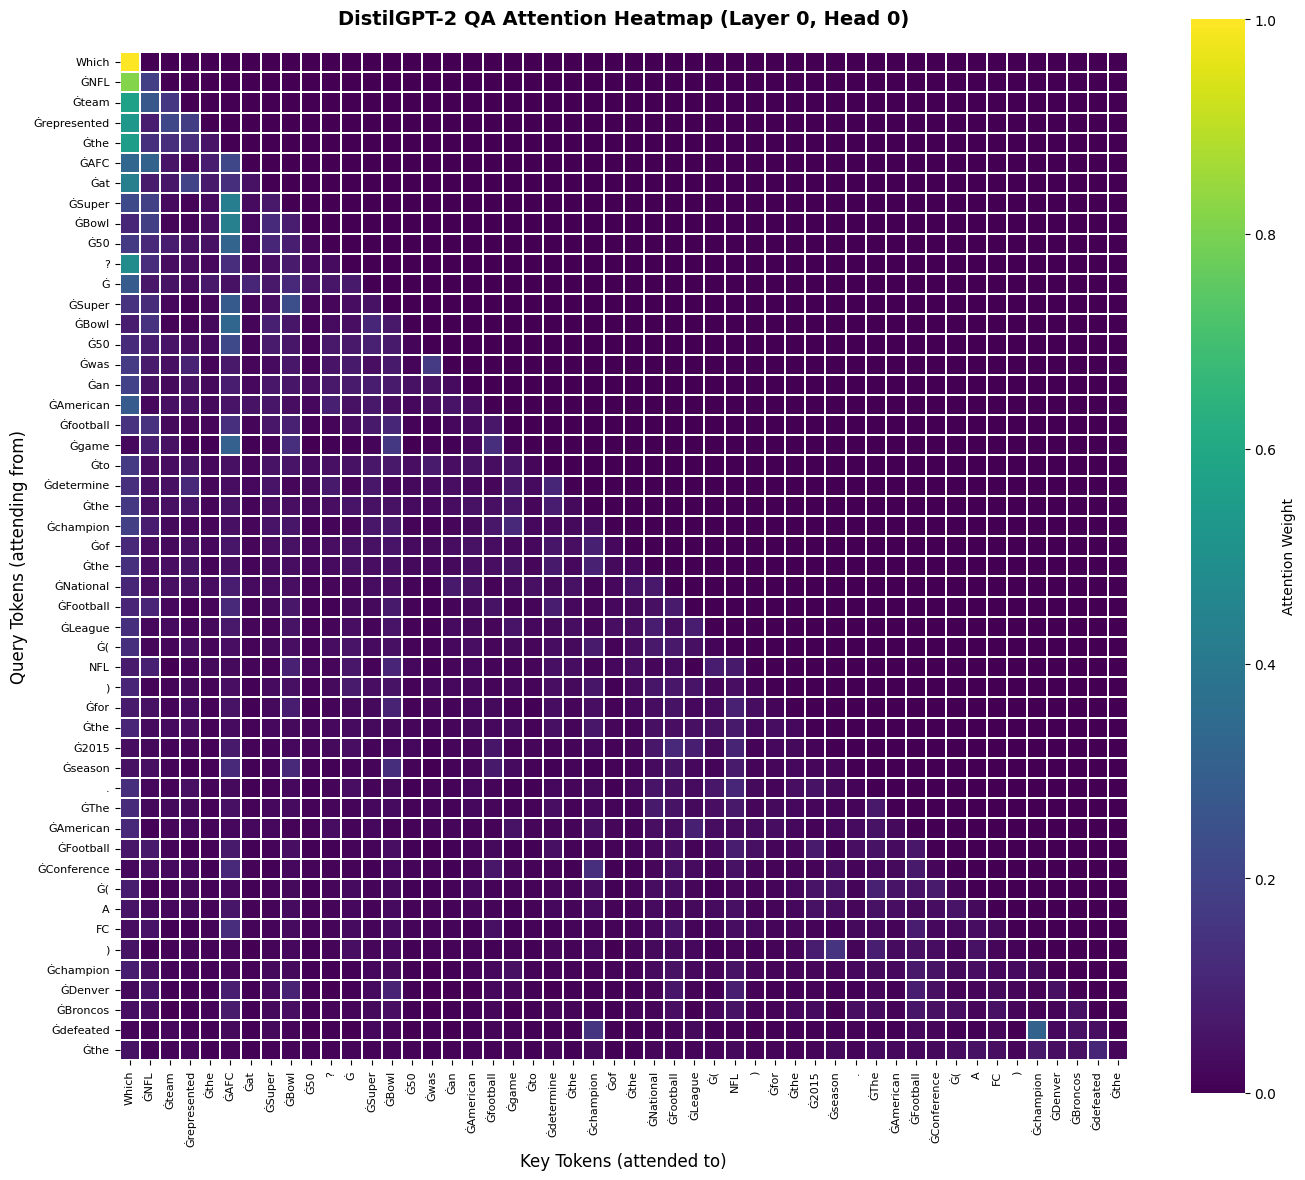

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2Config, GPT2ForQuestionAnswering

sample_example = val_subset[0]
question = sample_example['question']
context = sample_example['context'][:300]

print("Extracting attention weights from DistilGPT-2 (QA Model)...")
print(f"Question: {question}")
print(f"Context: {context[:100]}...")

text = question + "  " + context
inputs = qa_tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(DEVICE)

if not qa_model.config.output_attentions:
    config = GPT2Config.from_pretrained("distilgpt2", output_attentions=True)
    qa_model = GPT2ForQuestionAnswering.from_pretrained("distilgpt2", config=config).to(DEVICE)

qa_model.eval()
with torch.no_grad():
    outputs = qa_model(**inputs, output_attentions=True, return_dict=True)

attentions = outputs.attentions

if attentions is not None and len(attentions) > 0:
    valid_layer = None
    for i, attn in enumerate(attentions):
        if attn is not None:
            valid_layer = i
            break
   
    if valid_layer is None:
        raise ValueError("All attention layers are None. The model may not support output_attentions.")
   
    tokens = qa_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    max_tokens = min(50, len(tokens))
    tokens_display = tokens[:max_tokens]
   
    last_layer = None
    for i in range(len(attentions) - 1, -1, -1):
        if attentions[i] is not None:
            last_layer = i
            break
   
    if last_layer is not None:
        attention_all_heads = attentions[last_layer][0]
        attention_avg = attention_all_heads.mean(dim=0).detach().cpu().numpy()
        attention_matrix = attention_avg[:max_tokens, :max_tokens]
       
        print(f"\nSuccessfully extracted attention weights")
        print(f"Number of layers: {len(attentions)}")
        print(f"Attention matrix shape: {attention_matrix.shape}")
        print(f"Sample tokens: {tokens_display[:15]}")
        print(f"\nAttention Statistics:")
        print(f"  Max attention weight: {attention_matrix.max():.4f}")
        print(f"  Mean attention weight: {attention_matrix.mean():.4f}")
        print(f"  Attention to self (diagonal mean): {np.diag(attention_matrix).mean():.4f}")
        print(f"\nNote: This is a decoder-only model with causal attention.")
        print(f"      Tokens can only attend to previous tokens (upper triangular pattern).")
       
        print(f"\n" + "="*70)
        print(f"Visualizing a specific attention head (Layer {valid_layer}, Head 0)")
        print("="*70)
       
        attention_head = attentions[valid_layer][0][0].detach().cpu().numpy()
        attention_head_display = attention_head[:max_tokens, :max_tokens]
       
        plt.figure(figsize=(14, 12))
        sns.heatmap(attention_head_display,
                    xticklabels=tokens_display,
                    yticklabels=tokens_display,
                    cmap='viridis',
                    cbar_kws={'label': 'Attention Weight'},
                    square=True,
                    linewidths=0.1)
        plt.title(f'DistilGPT-2 QA Attention Heatmap (Layer {valid_layer}, Head 0)',
                  fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Key Tokens (attended to)', fontsize=12)
        plt.ylabel('Query Tokens (attending from)', fontsize=12)
        plt.xticks(rotation=90, fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout()
        plt.show()
else:
    raise ValueError("Could not extract attention weights from model outputs.")

In [146]:
def prepare_qa_sequences(dataset, max_docs=None):
    sequences = []
    subset = dataset if max_docs is None else dataset.select(range(min(len(dataset), max_docs)))
    for ex in subset:
        question = ex["question"].strip()
        context = ex["context"].strip()
        answer = ex["answers"]["text"][0].strip() if ex["answers"]["text"] else ""
        seq = f"Question: {question} Context: {context} Answer: {answer} <eos>"
        sequences.append(seq)
    return "\n".join(sequences)

train_qa_text = prepare_qa_sequences(squad["train"], max_docs=max_train_docs)
val_qa_text   = prepare_qa_sequences(squad["validation"], max_docs=max_val_docs)

In [147]:
os.makedirs("qa_tokenizer_data", exist_ok=True)
with open("qa_tokenizer_data/train.txt", "w", encoding="utf-8") as f:
    f.write(train_qa_text)
with open("qa_tokenizer_data/val.txt", "w", encoding="utf-8") as f:
    f.write(val_qa_text)

spm_model_prefix = "spm_model"
with open("qa_tokenizer_data/train.txt", "r", encoding="utf-8") as f:
    with open(f"{spm_model_prefix}.txt", "w", encoding="utf-8") as f_out:
        f_out.write(f.read())

sp = spm.SentencePieceProcessor()
tokenizer = tokenizer

sorry our kernel died here :( we were rerunning everything to make sure it worked, so we have output from the last time still working below.

In [148]:
def encode_text(text):
    return tokenizer.encode(text, out_type=int)

train_ids = encode_text(train_qa_text)
val_ids   = encode_text(val_qa_text)

max_train_tokens = block_size * max_train_sequences
max_val_tokens   = block_size * max_val_sequences

def ids_to_chunks(token_ids, max_tokens):
    usable = min(len(token_ids), max_tokens)
    usable = (usable // block_size) * block_size
    tensor = torch.tensor(token_ids[:usable], dtype=torch.long)
    return tensor.view(-1, block_size)

train_chunks = ids_to_chunks(train_ids, max_train_tokens)
val_chunks   = ids_to_chunks(val_ids, max_val_tokens)

print(f"Prepared {train_chunks.shape[0]} train chunks ({train_chunks.numel():,} tokens)")
print(f"Prepared {val_chunks.shape[0]} val chunks   ({val_chunks.numel():,} tokens)")
print(f"Vocabulary size: {tokenizer.get_piece_size()}")


: 

In [ ]:
train_loader = DataLoader(TensorDataset(train_chunks), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(TensorDataset(val_chunks), batch_size=batch_size)

In [45]:
d_model = 512              
num_layers = 6              
num_heads = 8
learning_rate = 1e-4
num_epochs = 5
dropout = 0.35

model = MiniGPT(vocab_size=tokenizer.get_piece_size(), d_model=d_model,
                num_layers=num_layers, num_heads=num_heads,
                block_size=block_size, dropout=dropout).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)


def compute_loss(logits, targets):
    # shift for next-token prediction
    return F.cross_entropy(
        logits[:, :-1, :].reshape(-1, logits.size(-1)),
        targets[:, 1:].reshape(-1)
    )


def run_epoch(loader, train: bool = True):
    total_loss = 0.0
    n_batches = 0
    if train:
        model.train()
    else:
        model.eval()
    for (batch,) in loader:
        batch = batch.to(DEVICE)
        if train:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits, _ = model(batch)
            loss = compute_loss(logits, batch)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(n_batches, 1)

print(f'PARAMS:\n\
        d_model = {d_model}\n\
        num_layers = {num_layers}\n\
        num_heads = {num_heads}\n\
        learning_rate = {learning_rate}\n\
        dropout = {dropout}\n\
')
history = []
for epoch in range(1, num_epochs + 1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    val_ppl = math.exp(val_loss)
    history.append((train_loss, val_loss, val_ppl))
    print(f"Epoch {epoch}: train_loss={train_loss:.3f} | val_loss={val_loss:.3f} | val_ppl={val_ppl:.1f}")


PARAMS:
        d_model = 512
        num_layers = 6
        num_heads = 8
        learning_rate = 0.0001
        dropout = 0.35

Epoch 1: train_loss=5.786 | val_loss=6.375 | val_ppl=587.0
Epoch 2: train_loss=4.384 | val_loss=6.366 | val_ppl=581.8
Epoch 3: train_loss=3.427 | val_loss=6.658 | val_ppl=778.7
Epoch 4: train_loss=2.517 | val_loss=7.082 | val_ppl=1190.3
Epoch 5: train_loss=1.720 | val_loss=7.542 | val_ppl=1886.0


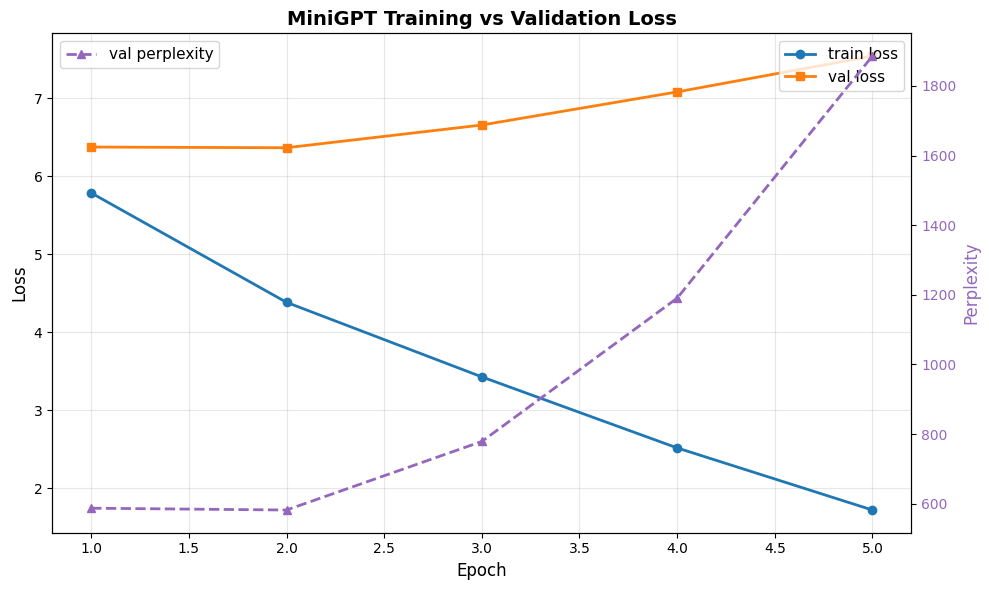


Training Summary:
  Final train loss: 1.720
  Final val loss: 7.542
  Final val perplexity: 1886.0
  Best val perplexity: 581.8 (epoch 2)


In [48]:
# Plot training curves
if history:
    epochs = list(range(1, len(history) + 1))
    train_losses = [h[0] for h in history]
    val_losses = [h[1] for h in history]
    val_ppls = [h[2] for h in history]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(epochs, train_losses, label='train loss', marker='o', linewidth=2)
    ax1.plot(epochs, val_losses, label='val loss', marker='s', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('MiniGPT Training vs Validation Loss', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=11)

    ax2 = ax1.twinx()
    ax2.plot(epochs, val_ppls, color='tab:purple', label='val perplexity', linestyle='--', marker='^', linewidth=2)
    ax2.set_ylabel('Perplexity', fontsize=12, color='tab:purple')
    ax2.tick_params(axis='y', labelcolor='tab:purple')
    ax2.legend(loc='upper left', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTraining Summary:")
    print(f"  Final train loss: {train_losses[-1]:.3f}")
    print(f"  Final val loss: {val_losses[-1]:.3f}")
    print(f"  Final val perplexity: {val_ppls[-1]:.1f}")
    print(f"  Best val perplexity: {min(val_ppls):.1f} (epoch {epochs[val_ppls.index(min(val_ppls))]})")
else:
    print('History is empty; run the training cell first.')


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

example = squad["validation"][0]
prompt = f"Question: {example['question']} Context: {example['context']} Answer:"

bos_id = tokenizer.PieceToId("<bos>")
prompt_ids = [bos_id] + tokenizer.encode(prompt, out_type=int)
input_ids = torch.tensor([prompt_ids], device=DEVICE)

# Enable gradients for input embeddings
input_emb = model.token_emb(input_ids)  # shape: (1, T, d_model)
input_emb.requires_grad_(True)


tensor([[[-1.2850,  0.4125,  0.1682,  ..., -2.0206, -1.4386, -0.1244],
         [ 0.5289,  0.2481,  0.7792,  ..., -0.3588,  0.8645, -1.5615],
         [ 0.6497,  0.1637, -0.0472,  ...,  0.6927,  2.3524,  0.3356],
         ...,
         [ 1.8641, -1.1505, -0.1184,  ...,  0.4958,  0.0420, -1.1473],
         [-0.2531,  0.7237, -0.9860,  ..., -0.8800, -1.2992,  0.4098],
         [ 0.6497,  0.1637, -0.0472,  ...,  0.6927,  2.3524,  0.3356]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [56]:
logits, _ = model.forward(idx=input_ids)
logits = logits[:, -1, :]  # last token prediction
pred_token_id = torch.argmax(logits, dim=-1)

# Pick scalar score for backprop
score = logits[0, pred_token_id]


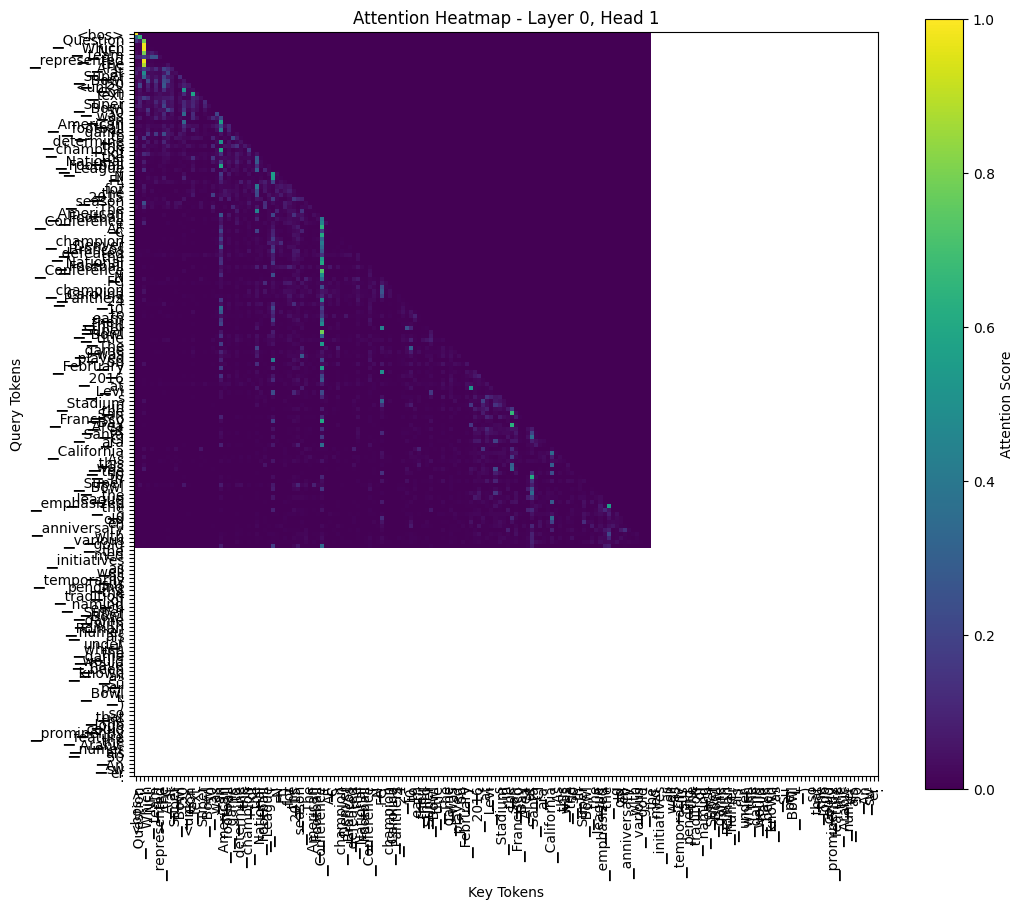

In [ ]:
import matplotlib.pyplot as plt
import torch

# Prepare input
example = squad["validation"][0]
prompt = f"Question: {example['question']} Context: {example['context']} Answer:"
bos_id = tokenizer.PieceToId("<bos>")
input_ids = torch.tensor([[bos_id] + tokenizer.encode(prompt, out_type=int)]).to(DEVICE)

# Forward with attention maps
model.eval()
with torch.no_grad():
    logits, attn_maps = model(input_ids, return_attn=True)

# Choose layer and head
layer_idx = -1  # last block
head_idx = 0    # first head
attn = attn_maps[layer_idx][0, head_idx].cpu().numpy()  # (T, T)

# Tokens
tokens = [tokenizer.IdToPiece(id) for id in input_ids[0].tolist()]

# Plot heatmap
# plt.figure(figsize=(12, 10))
# plt.imshow(attn, cmap="viridis")
# plt.colorbar(label="Attention Score")
# plt.xticks(range(len(tokens)), tokens, rotation=90)
# plt.yticks(range(len(tokens)), tokens)
# plt.xlabel("Key Tokens")
# plt.ylabel("Query Tokens")
# plt.title(f"Attention Heatmap - Layer {layer_idx+1}, Head {head_idx+1}")
# plt.show()


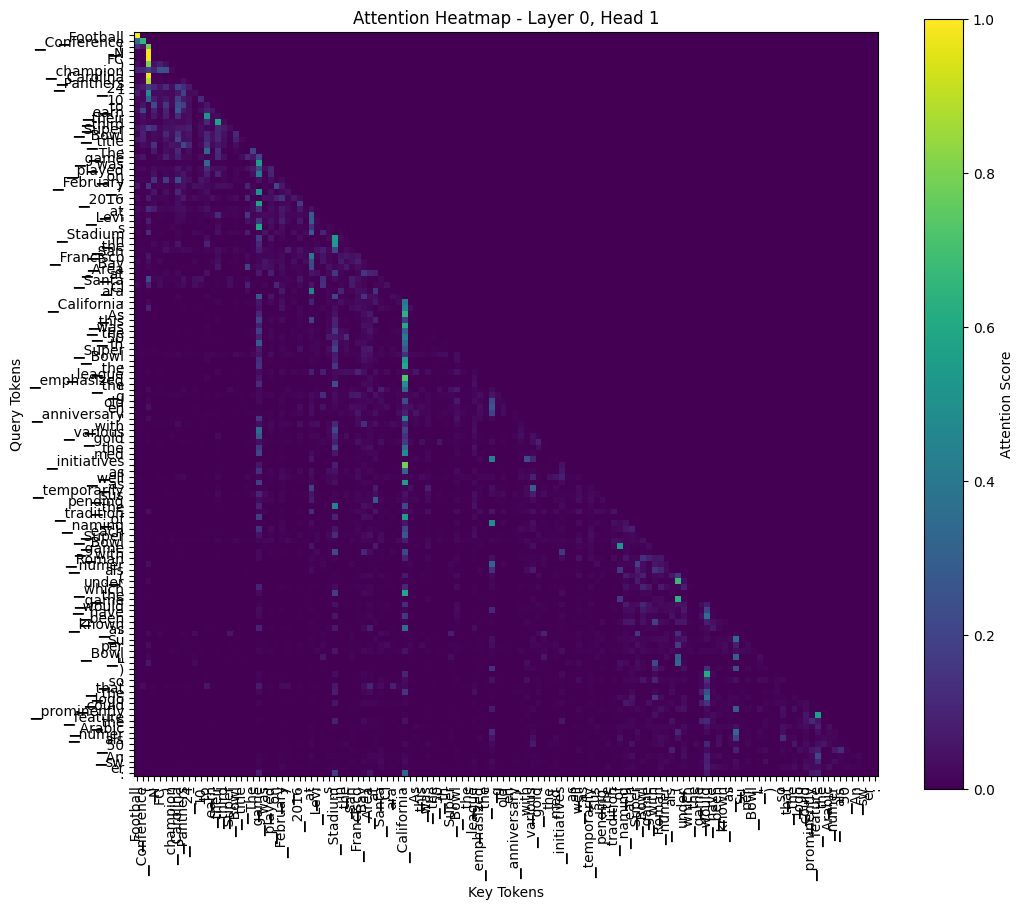

In [ ]:
T_attn = attn.shape[0]  # usually block_size
tokens_trunc = tokens[-T_attn:]  # keep only the tokens actually used in attention

plt.figure(figsize=(12, 10))
plt.imshow(attn, cmap="viridis")
plt.colorbar(label="Attention Score")
plt.xticks(range(len(tokens_trunc)), tokens_trunc, rotation=90)
plt.yticks(range(len(tokens_trunc)), tokens_trunc)
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.title(f"Attention Heatmap - Layer {layer_idx+1}, Head {head_idx+1}")
plt.show()


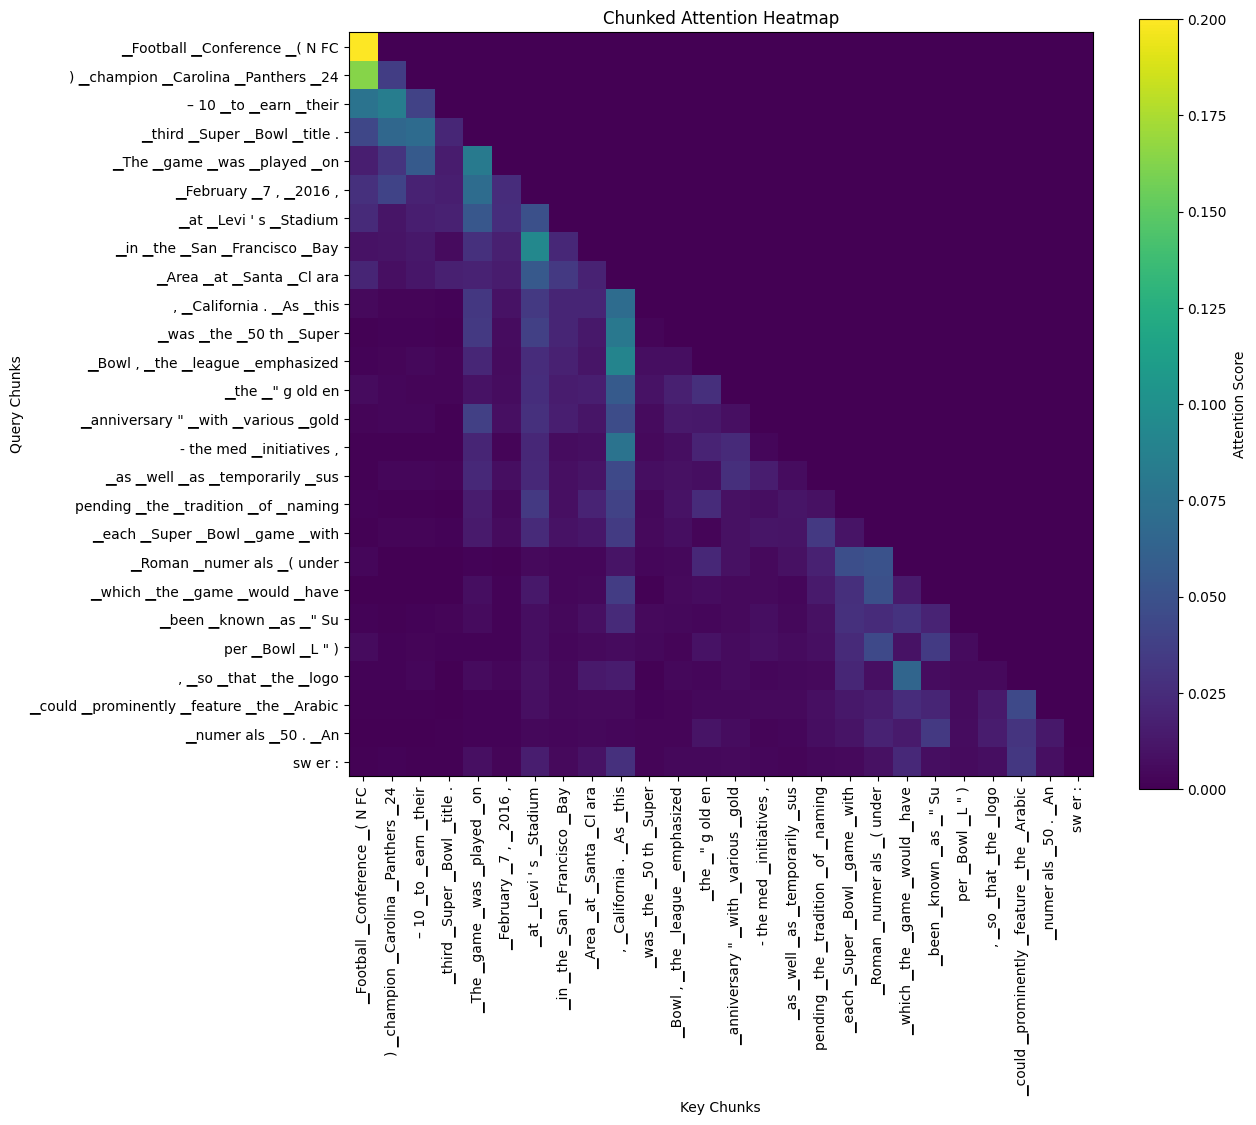

In [86]:
chunk_size = 5
T = attn.shape[0]  # actual attention size
tokens_trunc = tokens[-T:]  # only tokens corresponding to attention

# Compute number of chunks, include last partial chunk
num_chunks = (T + chunk_size - 1) // chunk_size  # ceiling division
attn_chunks = np.zeros((num_chunks, num_chunks), dtype=float)
chunk_labels = []

for i in range(num_chunks):
    start_i = i * chunk_size
    end_i = min((i+1) * chunk_size, T)
    chunk_labels.append(" ".join(tokens_trunc[start_i:end_i]))
    
    for j in range(num_chunks):
        start_j = j * chunk_size
        end_j = min((j+1) * chunk_size, T)
        attn_chunks[i, j] = attn[start_i:end_i, start_j:end_j].mean()

# Plot
plt.figure(figsize=(12, 10))
plt.imshow(attn_chunks, cmap="viridis")
plt.colorbar(label="Attention Score")
plt.xticks(range(num_chunks), chunk_labels, rotation=90)
plt.yticks(range(num_chunks), chunk_labels)
plt.xlabel("Key Chunks")
plt.ylabel("Query Chunks")
plt.title("Chunked Attention Heatmap")
plt.show()
